In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch
from torch import nn
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import pickle
from tqdm import tqdm
import seaborn as sns
np.random.seed(42)

# 1. Загрузка и первичный анализ данных
Первым шагом загрузим данные и посмотрим на них

In [ ]:
data = pd.read_csv('/content/1.txt', sep=';')

In [ ]:
data.head()

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_ENGINE_POWER,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,POLICY_INTERMEDIARY,INSURER_GENDER,POLICY_CLM_N,POLICY_CLM_GLT_N,POLICY_PRV_CLM_N,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,TRAIN,1,1,1,1,39,1,Москва,51,12,Land Rover,Discovery,245.0,0,1283202.0,856,F,0,0,N,N,1,0,0,0.0,0,0,0.0,Тульская,-1.00
1,TRAIN,2,1,1,1,50,5,Москва,35,7,Opel,Zafira,140.0,0,453000.0,N,M,0,0,0,0,1,1,0,0.0,0,4,0.0,Москва,-0.05
2,TRAIN,3,1,1,1,52,6,Москва,41,6,Kia,Soul,129.0,0,647718.0,N,F,0,0,1L,1L,0,0,0,0.0,0,1,12518.0,Московская,-0.07
3,TRAIN,4,1,1,1,50,5,Москва,36,12,Citroen,C-Crosser,170.0,0,757795.0,N,M,0,0,0,0,1,1,0,0.0,0,6,15000.0,Москва,0.05
4,TRAIN,5,1,1,0,52,6,Санкт-Петербург,42,5,Renault,Logan,102.0,0,604500.0,171,F,0,0,N,N,0,0,0,0.0,0,0,50000.0,Ленинградская,0.17


Проверим наличие пропущенных значений

In [ ]:
data.isnull().sum()

DATA_TYPE                        0
POLICY_ID                        0
POLICY_BEGIN_MONTH               0
POLICY_END_MONTH                 0
POLICY_IS_RENEWED                0
POLICY_SALES_CHANNEL             0
POLICY_SALES_CHANNEL_GROUP       0
POLICY_BRANCH                    0
POLICY_MIN_AGE                   0
POLICY_MIN_DRIVING_EXPERIENCE    0
VEHICLE_MAKE                     0
VEHICLE_MODEL                    0
VEHICLE_ENGINE_POWER             0
VEHICLE_IN_CREDIT                0
VEHICLE_SUM_INSURED              0
POLICY_INTERMEDIARY              0
INSURER_GENDER                   0
POLICY_CLM_N                     0
POLICY_CLM_GLT_N                 0
POLICY_PRV_CLM_N                 0
POLICY_PRV_CLM_GLT_N             0
CLIENT_HAS_DAGO                  0
CLIENT_HAS_OSAGO                 0
POLICY_COURT_SIGN                0
CLAIM_AVG_ACC_ST_PRD             0
POLICY_HAS_COMPLAINTS            0
POLICY_YEARS_RENEWED_N           0
POLICY_DEDUCT_VALUE              0
CLIENT_REGISTRATION_

Данные чистые и не имеют пропусков

Посмотрим на соотношение классов в обучающей выборке

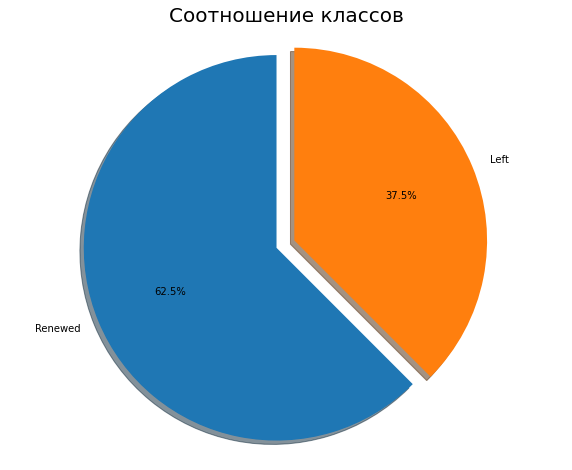

In [ ]:
labels = 'Renewed', 'Left'
sizes = [data.POLICY_IS_RENEWED[(data['POLICY_IS_RENEWED']==1) 
                                & (data['DATA_TYPE']=='TRAIN')].count(), 
         data.POLICY_IS_RENEWED[(data['POLICY_IS_RENEWED']==0 )
                                & (data['DATA_TYPE']=='TRAIN')].count()]

explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Соотношение классов", size = 20)
plt.show()

Классы также достаточно уравновешены, что позволяет учится на них без изменений.

# 2. Первичная модель.
Так как цель работы больше демонстрационная чем результативная, для наглядности сначала создадим простую модель и обучим на сырых данных, затем сделаем обработку признаков и сравним результаты.

Единственное что нужно сделать с данными, для такой модели, это закодировать категориальные составляющие в лейблы, сделаем это.

In [ ]:
data_simple = data.copy()

In [ ]:
# Так как модель не будет использоваться для предсказаний конечного результата,
# от тестовой части можно избавиться как и от айди клиентов.
data_simple = data_simple[data_simple.DATA_TYPE == 'TRAIN']
data_simple.drop(['POLICY_ID'], axis='columns', inplace=True)
data_simple.drop(['DATA_TYPE'], axis='columns', inplace=True)

Посмотрим на типы данных полученной таблицы

In [ ]:
data_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77407 entries, 0 to 96604
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   POLICY_BEGIN_MONTH             77407 non-null  int64  
 1   POLICY_END_MONTH               77407 non-null  int64  
 2   POLICY_IS_RENEWED              77407 non-null  int64  
 3   POLICY_SALES_CHANNEL           77407 non-null  int64  
 4   POLICY_SALES_CHANNEL_GROUP     77407 non-null  int64  
 5   POLICY_BRANCH                  77407 non-null  object 
 6   POLICY_MIN_AGE                 77407 non-null  int64  
 7   POLICY_MIN_DRIVING_EXPERIENCE  77407 non-null  int64  
 8   VEHICLE_MAKE                   77407 non-null  object 
 9   VEHICLE_MODEL                  77407 non-null  object 
 10  VEHICLE_ENGINE_POWER           77407 non-null  float64
 11  VEHICLE_IN_CREDIT              77407 non-null  int64  
 12  VEHICLE_SUM_INSURED            77407 non-null 

Некоторые признаки уже имеют кодировку лэйблов, осталось закодировать строчные колонки.

In [ ]:
le = preprocessing.LabelEncoder()

# Список колонок содержащие тип данных строка
indexes = data_simple.select_dtypes(include=object).columns.tolist()

for indx in indexes:
  le.fit(data_simple[indx])
  data_simple[indx] = le.transform(data_simple[indx])

In [ ]:
data_simple.head()

,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_ENGINE_POWER,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,POLICY_INTERMEDIARY,INSURER_GENDER,POLICY_CLM_N,POLICY_CLM_GLT_N,POLICY_PRV_CLM_N,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,1,1,1,39,1,0,51,12,39,173,245.0,0,1283202.0,1185,0,0,0,6,6,1,0,0,0.0,0,0,0.0,69,-1.00
1,1,1,1,50,5,0,35,7,50,510,140.0,0,453000.0,1332,1,0,0,0,0,1,1,0,0.0,0,5,0.0,40,-0.05
2,1,1,1,52,6,0,41,6,35,428,129.0,0,647718.0,1332,0,0,0,1,1,0,0,0,0.0,0,1,12518.0,41,-0.07
3,1,1,1,50,5,0,36,12,14,112,170.0,0,757795.0,1332,1,0,0,0,0,1,1,0,0.0,0,7,15000.0,40,0.05
4,1,1,0,52,6,1,42,5,53,290,102.0,0,604500.0,473,0,0,0,6,6,0,0,0,0.0,0,0,50000.0,35,0.17


In [ ]:
# Разобъем и отнормируем данне
feature_columns = ['POLICY_BEGIN_MONTH',
 'POLICY_END_MONTH',
 'POLICY_SALES_CHANNEL',
 'POLICY_SALES_CHANNEL_GROUP',
 'POLICY_BRANCH',
 'POLICY_MIN_AGE',
 'POLICY_MIN_DRIVING_EXPERIENCE',
 'VEHICLE_MAKE',
 'VEHICLE_MODEL',
 'VEHICLE_ENGINE_POWER',
 'VEHICLE_IN_CREDIT',
 'VEHICLE_SUM_INSURED',
 'POLICY_INTERMEDIARY',
 'INSURER_GENDER',
 'POLICY_CLM_N',
 'POLICY_CLM_GLT_N',
 'POLICY_PRV_CLM_N',
 'POLICY_PRV_CLM_GLT_N',
 'CLIENT_HAS_DAGO',
 'CLIENT_HAS_OSAGO',
 'POLICY_COURT_SIGN',
 'CLAIM_AVG_ACC_ST_PRD',
 'POLICY_HAS_COMPLAINTS',
 'POLICY_YEARS_RENEWED_N',
 'POLICY_DEDUCT_VALUE',
 'CLIENT_REGISTRATION_REGION',
 'POLICY_PRICE_CHANGE']
target_column = ['POLICY_IS_RENEWED']

In [ ]:
# Нормализуем данные
data_simple[feature_columns] = (data_simple[feature_columns]- 
      data_simple[feature_columns].mean()) / data_simple[feature_columns].std()

Разобьем данные на трейн и валидационную части, валидационную часть составим в соотношении классов 50 на 50, что позволит позволит применять различные метрики точности.

In [ ]:
# Заберем 20% данных от нулевого класса для валидации, в случайном порядке.
pr = len(data_simple[data_simple.POLICY_IS_RENEWED == 0])
pr = int(np.round(pr*0.2))


valid_cat1 = data_simple.copy()
valid_cat1 = valid_cat1[valid_cat1.POLICY_IS_RENEWED == 0]
valid_cat1 = shuffle(valid_cat1)
valid_cat1 = valid_cat1[:pr] 

In [ ]:
# и равнозначное колличество товаров 1-oй категории
valid_cat2 = data_simple.copy()
valid_cat2 = valid_cat2[valid_cat2.POLICY_IS_RENEWED == 1]
valid_cat2 = shuffle(valid_cat2)
valid_cat2 = valid_cat2[:pr] 

In [ ]:
# Соединим валидационные части обоих классов
valid = pd.concat([valid_cat1, valid_cat2])

In [ ]:
# Удалим валидационные данные из тестовой выборки и востановим значения индексов
data_simple.drop(valid.index, inplace=True)
data_simple = shuffle(data_simple)
data_simple.reset_index(level=0, inplace=True)
valid.reset_index(level=0, inplace=True)

In [ ]:
# Backup
with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_simple.pkl', 'wb') as f:
  pickle.dump(data_simple, f, pickle.HIGHEST_PROTOCOL)
with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_simple_valid.pkl', 'wb') as f:
  pickle.dump(valid, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load
with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_simple.pkl', 'rb') as f:
  data_simple = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_simple_valid.pkl', 'rb') as f:
  valid = pickle.load(f)

In [ ]:
# Подготовим выборку для модели

train_feat = data_simple[feature_columns]
train_labels = data_simple[target_column]

valid_feat = valid[feature_columns]
valid_labels = valid[target_column]

# Превратим в торч тензоры
train_feat = torch.FloatTensor(train_feat.values)
train_labels = torch.LongTensor(train_labels.values)

valid_feat = torch.FloatTensor(valid_feat.values)
valid_labels = torch.LongTensor(valid_labels.values)

Создадим простую модель.

In [ ]:
class LinearModel(nn.Module):
  def __init__(self, features_shape):
   super(LinearModel, self).__init__() 
   self.classifier = nn.Sequential(
       torch.nn.Linear(features_shape, 150),
       torch.nn.ReLU(), 
       torch.nn.Dropout(p=0.5), 
       torch.nn.BatchNorm1d(150), 
       torch.nn.Linear(150, 100), 
       torch.nn.ReLU(),
       torch.nn.Dropout(p=0.5),
       torch.nn.BatchNorm1d(100),
       torch.nn.Linear(100, 150), 
       torch.nn.ReLU(),
       torch.nn.Dropout(p=0.5),
       torch.nn.BatchNorm1d(150),
       torch.nn.Linear(150,2)
   )
  def forward(self, features):
    prob = self.classifier(features)
    return prob

In [ ]:
# Генератор батчей
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X)) #перемешиваем индексы
    X = X[perm] #перезадаем Х и У соотвественно новым индексам
    y = y[perm]
    num_batches = len(X) // batch_size #кол-во целвых батчей
    if num_batches * batch_size < len(X): #если дата не делится на цело, добовляем + батч
        num_batches += 1
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, len(X)) #когда данных станых меньше необходимого батча, в батч уйдет все что осталось
        X_batch, y_batch = X[start_index:end_index], y[start_index:end_index]
        yield (X_batch, y_batch)

In [ ]:
# Функция расчета точности
def roc_auc_compute_fn(y_preds, y_targets):
    from sklearn.metrics import roc_auc_score

    y_true = y_targets.numpy()
    y_pred = y_preds.numpy()
    return roc_auc_score(y_true, y_pred)

In [ ]:
# Функция тренировки модели
def train(num_epoch,name, sv = False):
    train_losses = []
    test_losses = []
    acc_roc = []
    best_acc = 0
    for i in range(num_epoch):
      epoch_train_loss = 0
      epoch_test_loss = 0
      epoch_acc = 0
      for feat, labels in batch_generator(train_feat, train_labels, 500):        
            model.train()
            # Посчитаем предсказание и лосс
            preds = model(feat.to(device))
            loss = loss_fn(preds, labels.squeeze(1).to(device))

            # зануляем градиент
            optimizer.zero_grad()

            # backward
            loss.backward()

            # обновляем веса 
            optimizer.step()

            # Запишем число (не тензор) в наши батчевые лоссы
            epoch_train_loss += loss.item()
            
            # Теперь посчитаем лосс на тесте
            model.eval()
            preds = model(valid_feat.to(device))
            
            loss = loss_fn(preds, valid_labels.squeeze(1).to(device))
            epoch_test_loss += loss.item()

            # Посчитаем точность
            preds = np.argmax(preds.detach().cpu(), axis =1)
            acc = roc_auc_compute_fn(preds,valid_labels.detach().cpu())
            epoch_acc += acc

            # Запомним лучшее, значение и при необходимости запомним веса
            way = '/content/drive/MyDrive/Colab Notebooks/Renesans/' + name +'.pt'
            if best_acc < acc:
              best_acc = acc
              if sv:
                torch.save(model.state_dict(), way)
          # Посчитаем общий лосс и точность за эпоху
      train_losses.append(epoch_train_loss/feat.shape[0])
      test_losses.append(epoch_test_loss/feat.shape[0])
      acc_roc.append(epoch_acc/feat.shape[0]) 
    return train_losses, test_losses, acc_roc, best_acc

In [ ]:
# Объявим модель
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LinearModel(train_feat.shape[1])
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)


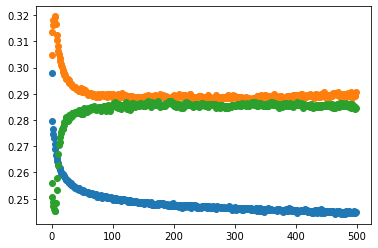

In [ ]:
train_losses, test_losses, acc_roc, best_acc  = train(500,'simple_model',True)
plt.scatter(range(len(train_losses)), train_losses)
plt.scatter(range(len(test_losses)), test_losses)
plt.scatter(range(len(acc_roc)), acc_roc)

In [ ]:
print('Лучшая точность:', np.round((best_acc*100), 2) , '%')

Лучшая точность: 65.11 %


# 3. Инжиниринг признаков.
**Для начала разберемся есть ли аномалии в данных**

In [ ]:
# Загрузим данные
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Renesans/1.txt', sep=';')

In [ ]:
# Посмотрим на колличество уникальных значений по классам
data.nunique()

DATA_TYPE                            2
POLICY_ID                        96605
POLICY_BEGIN_MONTH                  12
POLICY_END_MONTH                    12
POLICY_IS_RENEWED                    2
POLICY_SALES_CHANNEL                63
POLICY_SALES_CHANNEL_GROUP           8
POLICY_BRANCH                        2
POLICY_MIN_AGE                      68
POLICY_MIN_DRIVING_EXPERIENCE      112
VEHICLE_MAKE                        83
VEHICLE_MODEL                      549
VEHICLE_ENGINE_POWER               347
VEHICLE_IN_CREDIT                    2
VEHICLE_SUM_INSURED              44638
POLICY_INTERMEDIARY               1406
INSURER_GENDER                       2
POLICY_CLM_N                         7
POLICY_CLM_GLT_N                     7
POLICY_PRV_CLM_N                     7
POLICY_PRV_CLM_GLT_N                 7
CLIENT_HAS_DAGO                      2
CLIENT_HAS_OSAGO                     2
POLICY_COURT_SIGN                    2
CLAIM_AVG_ACC_ST_PRD               709
POLICY_HAS_COMPLAINTS    

In [ ]:
# И типа данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96605 entries, 0 to 96604
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATA_TYPE                      96605 non-null  object 
 1   POLICY_ID                      96605 non-null  int64  
 2   POLICY_BEGIN_MONTH             96605 non-null  int64  
 3   POLICY_END_MONTH               96605 non-null  int64  
 4   POLICY_IS_RENEWED              96605 non-null  int64  
 5   POLICY_SALES_CHANNEL           96605 non-null  int64  
 6   POLICY_SALES_CHANNEL_GROUP     96605 non-null  int64  
 7   POLICY_BRANCH                  96605 non-null  object 
 8   POLICY_MIN_AGE                 96605 non-null  int64  
 9   POLICY_MIN_DRIVING_EXPERIENCE  96605 non-null  int64  
 10  VEHICLE_MAKE                   96605 non-null  object 
 11  VEHICLE_MODEL                  96605 non-null  object 
 12  VEHICLE_ENGINE_POWER           96605 non-null 

In [ ]:
# Из типов данных не понятно, почему количество лет пролонгации имеет тип строки
# посмотрим на данные 
data['POLICY_YEARS_RENEWED_N'].unique()

array(['0', '4', '1', '6', '3', '2', '7', '5', '10', '8', 'N', '9'],
      dtype=object)

In [ ]:
# Узнаем сколько данных с позицией 'N'
len(data['POLICY_YEARS_RENEWED_N'][data.POLICY_YEARS_RENEWED_N == 'N'])

56

In [ ]:
# И есть ли они в тестовом датасете, если нет, то просто удалим такие строки
len(data[data.DATA_TYPE == 'TEST ']['POLICY_YEARS_RENEWED_N'][data.POLICY_YEARS_RENEWED_N == 'N'])

10

In [ ]:
# Т.к. данные класс присутсвует и в тестовом дата сете, 
# задим ему самый популярный класс
data.POLICY_YEARS_RENEWED_N.value_counts()

0     33249
1     25299
2     15278
3     11496
4      6215
5      2228
6      1748
7       832
8       104
9        82
N        56
10       18
Name: POLICY_YEARS_RENEWED_N, dtype: int64

In [ ]:
data.loc[data['POLICY_YEARS_RENEWED_N']=='N', 'POLICY_YEARS_RENEWED_N'] = 0

In [ ]:
# Переведем колонку к типа integer
data['POLICY_YEARS_RENEWED_N'] = data['POLICY_YEARS_RENEWED_N'].apply(int)

In [ ]:
# Для удобстав работы еще раз выведем начало данных
data.head()

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_ENGINE_POWER,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,POLICY_INTERMEDIARY,INSURER_GENDER,POLICY_CLM_N,POLICY_CLM_GLT_N,POLICY_PRV_CLM_N,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,TRAIN,1,1,1,1,39,1,Москва,51,12,Land Rover,Discovery,245.0,0,1283202.0,856,F,0,0,N,N,1,0,0,0.0,0,0,0.0,Тульская,-1.00
1,TRAIN,2,1,1,1,50,5,Москва,35,7,Opel,Zafira,140.0,0,453000.0,N,M,0,0,0,0,1,1,0,0.0,0,4,0.0,Москва,-0.05
2,TRAIN,3,1,1,1,52,6,Москва,41,6,Kia,Soul,129.0,0,647718.0,N,F,0,0,1L,1L,0,0,0,0.0,0,1,12518.0,Московская,-0.07
3,TRAIN,4,1,1,1,50,5,Москва,36,12,Citroen,C-Crosser,170.0,0,757795.0,N,M,0,0,0,0,1,1,0,0.0,0,6,15000.0,Москва,0.05
4,TRAIN,5,1,1,0,52,6,Санкт-Петербург,42,5,Renault,Logan,102.0,0,604500.0,171,F,0,0,N,N,0,0,0,0.0,0,0,50000.0,Ленинградская,0.17


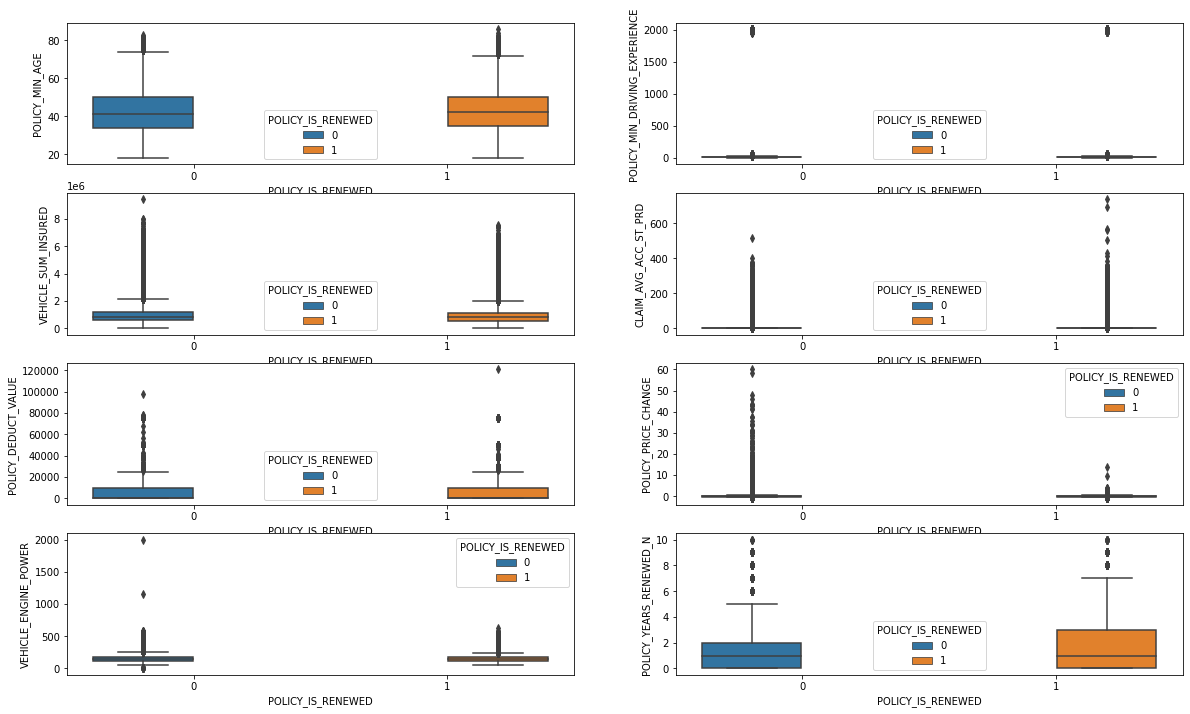

In [ ]:
# Построим boxplot для изучения выбросов
fig, axarr = plt.subplots(4, 2, figsize=(20, 12))
sns.boxplot(y='POLICY_MIN_AGE',x = 'POLICY_IS_RENEWED', hue = 'POLICY_IS_RENEWED',data = data, ax=axarr[0][0])
sns.boxplot(y='POLICY_MIN_DRIVING_EXPERIENCE',x = 'POLICY_IS_RENEWED', hue = 'POLICY_IS_RENEWED',data = data, ax=axarr[0][1])
sns.boxplot(y='VEHICLE_SUM_INSURED',x = 'POLICY_IS_RENEWED', hue = 'POLICY_IS_RENEWED',data = data, ax=axarr[1][0])
sns.boxplot(y='CLAIM_AVG_ACC_ST_PRD',x = 'POLICY_IS_RENEWED', hue = 'POLICY_IS_RENEWED',data = data, ax=axarr[1][1])
sns.boxplot(y='POLICY_DEDUCT_VALUE',x = 'POLICY_IS_RENEWED', hue = 'POLICY_IS_RENEWED',data = data, ax=axarr[2][0])
sns.boxplot(y='POLICY_PRICE_CHANGE',x = 'POLICY_IS_RENEWED', hue = 'POLICY_IS_RENEWED',data = data, ax=axarr[2][1])
sns.boxplot(y='VEHICLE_ENGINE_POWER',x = 'POLICY_IS_RENEWED', hue = 'POLICY_IS_RENEWED',data = data, ax=axarr[3][0])
sns.boxplot(y='POLICY_YEARS_RENEWED_N',x = 'POLICY_IS_RENEWED', hue = 'POLICY_IS_RENEWED',data = data, ax=axarr[3][1])



1.  Количество пожилых людей, допущенных к управлению тс заметно меньше, однако данные не имеют реальных аномалий (никаких 100+ граждан), поэтому данные признаки оставляем без изменений.
2.  В стаже вождения имеются очень сильные аномалии, посмотрим сколько их, если незначительно то просто удалим, если много -  рассчитаем средний стаж в зависимости от возраста.
3.  Страховая сумма по полису достигает 9.000.000,предполагаю что такое возможно, поэтому оставим значения без изменений. Посмотрим только на нулевые значения.
4.  Срок подачи заявления после ДТП регламентирован 15-ю днями, поэтому значения в 100+ и т.д явные выбросы. Предположим что значения указаны в часах.
5.  Сумма франшизы, это та часть которую компания не будет возвращать при наступлении страхового случая. В этом вопросе тоже не ориентируюсь, поэтому посмотрим какая страховая сумма на выбросах, и что в тестовой части.
6.  Сумма страхового полиса в отдельных случаях выросла на 60%, при расчете используются разные коэффициенты на основе клиента (дтп, ремонты и прочее), так что допустим возможность такого роста.
7. В тестовой части есть машины где мощность двигателя превышает более 1000 л.с. такие значения удалим. И посмотрим на нулевые значения
8. Максимальный срок полиса КАСКО 10 лет, то не противоречит нормам. Оставим без изменений.

*Стаж вождения*

In [ ]:
# Посмотрим что со стажем вождения
data['POLICY_MIN_DRIVING_EXPERIENCE'][data.POLICY_MIN_DRIVING_EXPERIENCE > 60]

239      1986
386      1988
543      2008
551      2002
811      1996
         ... 
96358    1990
96360    2013
96375    1992
96381    2001
96455    1984
Name: POLICY_MIN_DRIVING_EXPERIENCE, Length: 992, dtype: int64

In [ ]:
# По всей видимости эти данные - год получения ВУ, расчитаем стаж этих клиентов
# на 2020 год.
data.loc[data['POLICY_MIN_DRIVING_EXPERIENCE']>80, 'POLICY_MIN_DRIVING_EXPERIENCE'] -= 2020

In [ ]:
data['POLICY_MIN_DRIVING_EXPERIENCE'] = abs(data['POLICY_MIN_DRIVING_EXPERIENCE'])

In [ ]:
# Проверим распределение значений
print('max:',data['POLICY_MIN_DRIVING_EXPERIENCE'].max(), 'min:', data['POLICY_MIN_DRIVING_EXPERIENCE'].min())

max: 64 min: 0


*Страховая сумма*


In [ ]:
# Посмотрим на количество нулевых значений
data['VEHICLE_SUM_INSURED'][data.VEHICLE_SUM_INSURED ==0].count()

42

In [ ]:
# Также стоит проверить есть ли выбросы с очень маленькими размерами страховок
data['VEHICLE_SUM_INSURED'][(data.VEHICLE_SUM_INSURED >0) & (data.VEHICLE_SUM_INSURED < 80000)]

1689     72171.0
17401    65359.0
26182    44550.0
76783    23230.0
Name: VEHICLE_SUM_INSURED, dtype: float64

In [ ]:
# Данные выглядят адекватно, нужно только избавиться от нулей
data.loc[data['VEHICLE_SUM_INSURED'] == 0, 'VEHICLE_SUM_INSURED'] = data['VEHICLE_SUM_INSURED'][data.VEHICLE_SUM_INSURED !=0].mean()

*Сроки подачи*

In [ ]:
# Посмотрим на колличество выбросов и какие там значения
x = data['CLAIM_AVG_ACC_ST_PRD'][data.CLAIM_AVG_ACC_ST_PRD > 15]
y = data['CLAIM_AVG_ACC_ST_PRD'].mean()
z = data['CLAIM_AVG_ACC_ST_PRD'].max()
print(x,'\n',y,'\n', z)

40        48.0
44        18.0
64        17.5
67        33.0
74        33.0
         ...  
96518    108.0
96521     26.0
96559     18.0
96580     34.0
96584     79.0
Name: CLAIM_AVG_ACC_ST_PRD, Length: 5697, dtype: float64 
 3.8771102090580922 
 737.0


In [ ]:
data.loc[data['CLAIM_AVG_ACC_ST_PRD']>15, 'CLAIM_AVG_ACC_ST_PRD'] //= 24

Для начала необходимо посомтреть что с этим параметром в тестовой выборке.

In [ ]:
data[data.DATA_TYPE == 'TEST ']['CLAIM_AVG_ACC_ST_PRD'].max()

15.0

В тестовой выборке значение не превышают установленного срока, поэтому можем спокойно удалить все строки из трейн части содержащие значение больше 15

In [ ]:
drop_index = data[data['CLAIM_AVG_ACC_ST_PRD'] > 15].index

In [ ]:
data.drop(drop_index, inplace = True)

*Сумма франшизы*

In [ ]:
data[data.DATA_TYPE == 'TEST ']['POLICY_DEDUCT_VALUE'].max()

97926.0

In [ ]:
data[data['POLICY_DEDUCT_VALUE'] > 97925]

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_ENGINE_POWER,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,POLICY_INTERMEDIARY,INSURER_GENDER,POLICY_CLM_N,POLICY_CLM_GLT_N,POLICY_PRV_CLM_N,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
2348,TEST,2349,8,8,0,8,4,Санкт-Петербург,28,9,Porsche,Panamera,440.0,0,7120000.0,94,M,0,0,N,N,1,1,0,0.0,0,0,97926.0,Санкт-Петербург,0.00
80834,TRAIN,80835,4,4,1,2,4,Санкт-Петербург,47,28,Opel,Meriva,140.0,1,604365.0,1180,F,0,0,0,0,0,1,0,0.0,0,3,120873.0,Ленинградская,-0.31


Предположим что такие значения имеют место быть, и в случаем с опелем, например: условная франшиза, оставим параметры без изменений.

*Мощность двигателя*

In [ ]:
drop_index = data[data['VEHICLE_ENGINE_POWER'] > 1000].index

In [ ]:
data.drop(drop_index, inplace = True)

In [ ]:
# теперь нулевые значения
data['VEHICLE_ENGINE_POWER'][data.VEHICLE_ENGINE_POWER ==0].count()

17

In [ ]:
data.loc[data['VEHICLE_ENGINE_POWER'] == 0, 'VEHICLE_ENGINE_POWER'] = data['VEHICLE_ENGINE_POWER'][data.VEHICLE_ENGINE_POWER !=0].mean()

In [ ]:
# Проверим наличие других выбросов
data['VEHICLE_ENGINE_POWER'][(data.VEHICLE_ENGINE_POWER >0) & (data.VEHICLE_ENGINE_POWER < 50)]

Series([], Name: VEHICLE_ENGINE_POWER, dtype: float64)

In [ ]:
# Сбросим индекс т.к. удаляли некоторые строки
data.reset_index(level=0, inplace=True)

In [ ]:
# Backup
with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_without_anomaly.pkl', 'wb') as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# load
with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_without_anomaly.pkl', 'rb') as f:
  data = pickle.load(f)

**Данные очищены от аномалий, осталось разобраться с категориальными и добавить несколько новых признаков**

Добавим признак, характеризующий были ли аварии

In [ ]:
data['POLICY_CLM_N'].unique()
data['DTP'] = data['POLICY_CLM_N']
# Если информация о ДТП недоступна, то считаем что дтп не было
data.loc[data['DTP'] == 'n/d', 'DTP'] = 0
data.loc[data['DTP'] == '0', 'DTP'] = 0
data.loc[data['DTP'] != 0, 'DTP'] = 1

Признак канала продажи и его группы закодируем частотным способом.

In [ ]:
data['SALE_CHANNEL'] = data[['POLICY_SALES_CHANNEL', 'POLICY_SALES_CHANNEL_GROUP']].apply(tuple, axis=1)
# Посчитаем частоту, которая и будет нашим признаком
freq = data.groupby('SALE_CHANNEL').size()
data.loc[:,'SALE_CHANNEL_FREQ'] = data['SALE_CHANNEL'].map(freq)

Так же поступим с регионом

In [ ]:
freq = data.groupby('CLIENT_REGISTRATION_REGION').size()
data.loc[:,'REGION'] = data['CLIENT_REGISTRATION_REGION'].map(freq)

И с посредником

In [ ]:
freq = data.groupby('POLICY_INTERMEDIARY').size()

In [ ]:
# Но если посредника не было, оставим показатель равным 0
freq.N = 0

In [ ]:
data.loc[:,'INTERMEDIARY'] = data['POLICY_INTERMEDIARY'].map(freq)

Остались марка и модель автомобиля. Модель автомобиля должна быть достаточно весомым признаком. Поэтому попробуем описать каждую модель автомобиля 2-мя признаками:
 
Первым признаком рассчитаем стоимость 1-ой лошадиной силы относительно всех других моделей, конечно такая характеристика будет иметь корреляцию с стоимостью страховки, но не повторять ее полностью.
Как второй признак найдем некий интерпретируемый аналог года автомобиля, отталкиваясь от идеи, что чем меньше берут авто в кредит, тем более старым является автомобиль. Приведу пример: имеем новый автомобиль эконом класса и 5-ти летний автомобиль премиум класса, рыночная стоимость двух автомобилей одинаковая, страховая сумма тоже схожа, однако новый автомобиль будут брать в кредит чаще чем б\у.
 



In [ ]:
# Первым шагом объеденим модель и марку авто
data['MODEL'] = data[['VEHICLE_MAKE', 'VEHICLE_MODEL']].apply(tuple, axis=1)

In [ ]:
# Выделим интересующие нас категории и расчитаем стоимость одной лс
data_model = data[['MODEL','VEHICLE_SUM_INSURED','VEHICLE_ENGINE_POWER']]
data_model = data_model.groupby('MODEL').sum()
data_model.loc[:,'PRICE'] = (data_model['VEHICLE_SUM_INSURED'] 
                             / data_model['VEHICLE_ENGINE_POWER'])
# Теперь добавим столбец к нашим данным
data_model.drop(['VEHICLE_SUM_INSURED'], axis='columns', inplace=True)
data_model.drop(['VEHICLE_ENGINE_POWER'], axis='columns', inplace=True)
data['PRICE'] = data['MODEL'].map(data_model.squeeze())

In [ ]:
# Выделим интересующие нас категории и расчитаем стоимость одной лс
data_model = data[['MODEL','VEHICLE_IN_CREDIT']]
data_model = data_model.groupby('MODEL').sum()
data_model.loc[:,'YEAR'] = data_model['VEHICLE_IN_CREDIT'] 

In [ ]:
# Теперь добавим столбец к нашим данным
data_model.drop(['VEHICLE_IN_CREDIT'], axis='columns', inplace=True)
data['YEAR'] = data['MODEL'].map(data_model.squeeze())

И добавим статистику ДТП по производителям

In [ ]:
data_model = data[['VEHICLE_MAKE','DTP']]
data_model = data_model.groupby('VEHICLE_MAKE').sum()
data['DTP_ST'] = data['VEHICLE_MAKE'].map(data_model.squeeze())

Удалим не нужные столбцы

In [ ]:
# Удалим не нужные столбцы
data.drop(['VEHICLE_MAKE'], axis='columns', inplace=True)
data.drop(['VEHICLE_MODEL'], axis='columns', inplace=True)
data.drop(['MODEL'], axis='columns', inplace=True)
data.drop(['index'], axis='columns', inplace=True)
data.drop(['POLICY_SALES_CHANNEL'], axis='columns', inplace=True)
data.drop(['POLICY_SALES_CHANNEL_GROUP'], axis='columns', inplace=True)
data.drop(['CLIENT_REGISTRATION_REGION'], axis='columns', inplace=True)
data.drop(['SALE_CHANNEL'], axis='columns', inplace=True)
data.drop(['POLICY_INTERMEDIARY'], axis='columns', inplace=True)

In [ ]:
data

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_ENGINE_POWER,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,INSURER_GENDER,POLICY_CLM_N,POLICY_CLM_GLT_N,POLICY_PRV_CLM_N,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,POLICY_PRICE_CHANGE,DTP,SALE_CHANNEL_FREQ,REGION,INTERMEDIARY,PRICE,YEAR,DTP_ST
0,TRAIN,1,1,1,1,Москва,51,12,245.0,0,1283202.0,F,0,0,N,N,1,0,0,0.0,0,0,0.0,-1.00,0,451,219,11,9042.886251,76,656
1,TRAIN,2,1,1,1,Москва,35,7,140.0,0,453000.0,M,0,0,0,0,1,1,0,0.0,0,4,0.0,-0.05,0,16175,34415,0,4935.366229,46,439
2,TRAIN,3,1,1,1,Москва,41,6,129.0,0,647718.0,F,0,0,1L,1L,0,0,0,0.0,0,1,12518.0,-0.07,0,24726,12819,0,5371.254659,144,3314
3,TRAIN,4,1,1,1,Москва,36,12,170.0,0,757795.0,M,0,0,0,0,1,1,0,0.0,0,6,15000.0,0.05,0,16175,34415,0,4395.529303,7,76
4,TRAIN,5,1,1,0,Санкт-Петербург,42,5,102.0,0,604500.0,F,0,0,N,N,0,0,0,0.0,0,0,50000.0,0.17,0,24726,5876,1310,4096.483477,233,2196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96589,TRAIN,96601,3,3,1,Москва,38,6,199.0,0,1799000.0,M,0,0,N,N,1,1,0,0.0,0,0,0.0,-0.14,0,11395,12819,11185,4541.229379,177,2319
96590,TRAIN,96602,4,3,1,Санкт-Петербург,30,6,249.0,0,3000500.0,M,0,0,0,0,1,1,0,0.0,0,1,0.0,0.00,0,16175,38851,0,11254.362762,30,436
96591,TRAIN,96603,3,3,1,Москва,59,31,140.0,0,561700.0,M,1S,1S,0,0,1,1,0,3.0,0,2,0.0,-0.22,1,16175,34415,0,4840.960514,54,439
96592,TRAIN,96604,3,3,1,Москва,41,19,173.0,0,1783992.0,M,0,0,0,0,0,1,0,0.0,0,1,0.0,0.04,0,24726,12819,3663,9204.025063,89,2973


Осталось закодировать оставшиеся признаки

In [ ]:
data = pd.get_dummies(data, columns=['VEHICLE_IN_CREDIT'])
data = pd.get_dummies(data, columns=['POLICY_BRANCH'])
data = pd.get_dummies(data, columns=['INSURER_GENDER'])
data = pd.get_dummies(data, columns=['POLICY_CLM_N'])
data = pd.get_dummies(data, columns=['POLICY_CLM_GLT_N'])
data = pd.get_dummies(data, columns=['POLICY_PRV_CLM_N'])
data = pd.get_dummies(data, columns=['POLICY_PRV_CLM_GLT_N'])
data = pd.get_dummies(data, columns=['CLIENT_HAS_DAGO'])
data = pd.get_dummies(data, columns=['CLIENT_HAS_OSAGO'])
data = pd.get_dummies(data, columns=['POLICY_COURT_SIGN'])
data = pd.get_dummies(data, columns=['DTP'])

In [ ]:
data

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_ENGINE_POWER,VEHICLE_SUM_INSURED,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,POLICY_PRICE_CHANGE,SALE_CHANNEL_FREQ,REGION,INTERMEDIARY,PRICE,YEAR,DTP_ST,VEHICLE_IN_CREDIT_0,VEHICLE_IN_CREDIT_1,POLICY_BRANCH_Москва,POLICY_BRANCH_Санкт-Петербург,INSURER_GENDER_F,INSURER_GENDER_M,POLICY_CLM_N_0,POLICY_CLM_N_1L,POLICY_CLM_N_1S,POLICY_CLM_N_2,POLICY_CLM_N_3,POLICY_CLM_N_4+,POLICY_CLM_N_n/d,POLICY_CLM_GLT_N_0,POLICY_CLM_GLT_N_1L,POLICY_CLM_GLT_N_1S,POLICY_CLM_GLT_N_2,POLICY_CLM_GLT_N_3,POLICY_CLM_GLT_N_4+,POLICY_CLM_GLT_N_n/d,POLICY_PRV_CLM_N_0,POLICY_PRV_CLM_N_1L,POLICY_PRV_CLM_N_1S,POLICY_PRV_CLM_N_2,POLICY_PRV_CLM_N_3,POLICY_PRV_CLM_N_4+,POLICY_PRV_CLM_N_N,POLICY_PRV_CLM_GLT_N_0,POLICY_PRV_CLM_GLT_N_1L,POLICY_PRV_CLM_GLT_N_1S,POLICY_PRV_CLM_GLT_N_2,POLICY_PRV_CLM_GLT_N_3,POLICY_PRV_CLM_GLT_N_4+,POLICY_PRV_CLM_GLT_N_N,CLIENT_HAS_DAGO_0,CLIENT_HAS_DAGO_1,CLIENT_HAS_OSAGO_0,CLIENT_HAS_OSAGO_1,POLICY_COURT_SIGN_0,POLICY_COURT_SIGN_1,DTP_0,DTP_1
0,TRAIN,1,1,1,1,51,12,245.0,1283202.0,0.0,0,0,0.0,-1.00,451,219,11,9042.886251,76,656,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0
1,TRAIN,2,1,1,1,35,7,140.0,453000.0,0.0,0,4,0.0,-0.05,16175,34415,0,4935.366229,46,439,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0
2,TRAIN,3,1,1,1,41,6,129.0,647718.0,0.0,0,1,12518.0,-0.07,24726,12819,0,5371.254659,144,3314,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0
3,TRAIN,4,1,1,1,36,12,170.0,757795.0,0.0,0,6,15000.0,0.05,16175,34415,0,4395.529303,7,76,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0
4,TRAIN,5,1,1,0,42,5,102.0,604500.0,0.0,0,0,50000.0,0.17,24726,5876,1310,4096.483477,233,2196,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96589,TRAIN,96601,3,3,1,38,6,199.0,1799000.0,0.0,0,0,0.0,-0.14,11395,12819,11185,4541.229379,177,2319,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0
96590,TRAIN,96602,4,3,1,30,6,249.0,3000500.0,0.0,0,1,0.0,0.00,16175,38851,0,11254.362762,30,436,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0
96591,TRAIN,96603,3,3,1,59,31,140.0,561700.0,3.0,0,2,0.0,-0.22,16175,34415,0,4840.960514,54,439,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1
96592,TRAIN,96604,3,3,1,41,19,173.0,1783992.0,0.0,0,1,0.0,0.04,24726,12819,3663,9204.025063,89,2973,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0


**Разделим данные на трейн и тест и сохраним**

In [ ]:
data_train = data[data.DATA_TYPE == 'TRAIN']
# Удалим айди и категорию в трейн части
data_train.drop(['POLICY_ID'], axis='columns', inplace=True)
data_train.drop(['DATA_TYPE'], axis='columns', inplace=True)

In [ ]:
data_test = data[data.DATA_TYPE == 'TEST ']
# Удалим категорию
data_test.drop(['DATA_TYPE'], axis='columns', inplace=True)

In [ ]:
# Backup
with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_train_rdy2.pkl', 'wb') as f:
  pickle.dump(data_train, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_test_rdy2.pkl', 'wb') as f:
  pickle.dump(data_test, f, pickle.HIGHEST_PROTOCOL)

# 4. Вторичная модель

Проверим как изменилось качество, применив ту же модель что и в 1 главе.

In [ ]:
# load
with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_train_rdy2.pkl', 'rb') as f:
  data_train = pickle.load(f)

In [ ]:
# Нормализуем только не категориальные данные
feature_columns = ['POLICY_BEGIN_MONTH',
 'POLICY_END_MONTH',
 'POLICY_MIN_AGE',
 'POLICY_MIN_DRIVING_EXPERIENCE',
 'VEHICLE_ENGINE_POWER',
 'VEHICLE_SUM_INSURED',
 'CLAIM_AVG_ACC_ST_PRD',
 'POLICY_YEARS_RENEWED_N',
 'POLICY_DEDUCT_VALUE',
 'POLICY_PRICE_CHANGE',
 'SALE_CHANNEL_FREQ',
 'REGION',
 'INTERMEDIARY',
 'PRICE',
 'YEAR',
 'DTP_ST'
 ]
target_column = ['POLICY_IS_RENEWED']

In [ ]:
# Нормализуем данные
data_train[feature_columns] = (data_train[feature_columns]- 
      data_train[feature_columns].mean()) / data_train[feature_columns].std()

In [ ]:
# Заберем 20% данных от нулевого класса для валидации, в случайном порядке.
pr = len(data_train[data_train.POLICY_IS_RENEWED == 0])
pr = int(np.round(pr*0.2))


valid_cat1 = data_train.copy()
valid_cat1 = valid_cat1[valid_cat1.POLICY_IS_RENEWED == 0]
valid_cat1 = shuffle(valid_cat1)
valid_cat1 = valid_cat1[:pr] 

In [ ]:
# и равнозначное колличество товаров 1-oй категории
valid_cat2 = data_train.copy()
valid_cat2 = valid_cat2[valid_cat2.POLICY_IS_RENEWED == 1]
valid_cat2 = shuffle(valid_cat2)
valid_cat2 = valid_cat2[:pr] 

In [ ]:
# Соединим валидационные части обоих классов
valid = pd.concat([valid_cat1, valid_cat2])

In [ ]:
# Удалим валидационные данные из тестовой выборки и востановим значения индексов
data_train.drop(valid.index, inplace=True)
data_train = shuffle(data_train)
data_train.reset_index(level=0, inplace=True)
valid.reset_index(level=0, inplace=True)

In [ ]:
# Backup
with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_norm2.pkl', 'wb') as f:
  pickle.dump(data_train, f, pickle.HIGHEST_PROTOCOL)
with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_norm_valid2.pkl', 'wb') as f:
  pickle.dump(valid, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load
with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_norm2.pkl', 'rb') as f:
  data_train = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_norm_valid2.pkl', 'rb') as f:
  valid = pickle.load(f)

In [ ]:
y_train = data_train['POLICY_IS_RENEWED']
data_train.drop(['POLICY_IS_RENEWED'], axis='columns', inplace=True)
data_train.drop(['index'], axis='columns', inplace=True)
y_test = valid['POLICY_IS_RENEWED']
valid.drop(['POLICY_IS_RENEWED'], axis='columns', inplace=True)
valid.drop(['index'], axis='columns', inplace=True)

In [ ]:
data_train

,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_ENGINE_POWER,VEHICLE_SUM_INSURED,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,POLICY_PRICE_CHANGE,SALE_CHANNEL_FREQ,REGION,INTERMEDIARY,PRICE,YEAR,DTP_ST,VEHICLE_IN_CREDIT_0,VEHICLE_IN_CREDIT_1,POLICY_BRANCH_Москва,POLICY_BRANCH_Санкт-Петербург,INSURER_GENDER_F,INSURER_GENDER_M,POLICY_CLM_N_0,POLICY_CLM_N_1L,POLICY_CLM_N_1S,POLICY_CLM_N_2,POLICY_CLM_N_3,POLICY_CLM_N_4+,POLICY_CLM_N_n/d,POLICY_CLM_GLT_N_0,POLICY_CLM_GLT_N_1L,POLICY_CLM_GLT_N_1S,POLICY_CLM_GLT_N_2,POLICY_CLM_GLT_N_3,POLICY_CLM_GLT_N_4+,POLICY_CLM_GLT_N_n/d,POLICY_PRV_CLM_N_0,POLICY_PRV_CLM_N_1L,POLICY_PRV_CLM_N_1S,POLICY_PRV_CLM_N_2,POLICY_PRV_CLM_N_3,POLICY_PRV_CLM_N_4+,POLICY_PRV_CLM_N_N,POLICY_PRV_CLM_GLT_N_0,POLICY_PRV_CLM_GLT_N_1L,POLICY_PRV_CLM_GLT_N_1S,POLICY_PRV_CLM_GLT_N_2,POLICY_PRV_CLM_GLT_N_3,POLICY_PRV_CLM_GLT_N_4+,POLICY_PRV_CLM_GLT_N_N,CLIENT_HAS_DAGO_0,CLIENT_HAS_DAGO_1,CLIENT_HAS_OSAGO_0,CLIENT_HAS_OSAGO_1,POLICY_COURT_SIGN_0,POLICY_COURT_SIGN_1,DTP_0,DTP_1
0,1.504896,1.509956,-0.898503,-0.503894,2.639691,1.192492,0.019156,0,-0.933335,0.387983,0.243012,0.085608,0.713148,-0.513311,0.063986,-1.024884,-1.860497,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1
1,0.327373,0.333534,0.781290,1.213171,-0.600848,-0.635603,-0.375956,0,0.314939,-0.573721,0.099718,1.067659,0.713148,-0.362819,-0.297695,-0.751681,-0.269081,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0
2,1.210515,1.215850,1.621186,2.393653,-1.196809,-0.580836,0.019156,0,-0.309198,-0.573721,0.087777,-0.463358,-1.379403,-0.513311,-0.602747,2.271502,0.289586,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1
3,-0.261389,-0.254676,1.994473,0.998538,-0.265619,-0.473330,1.204490,0,-0.309198,0.387983,-0.139106,0.647551,0.713148,-0.513311,-0.350569,-0.255129,-0.736277,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1
4,0.916134,0.921745,0.501324,0.032689,0.274470,0.205792,4.365382,0,-0.933335,-0.573721,-0.485400,-0.463358,0.356566,0.146339,-0.145227,-0.472495,-1.468052,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65781,0.327373,0.333534,1.061255,0.032689,-0.153877,-0.018730,-0.375956,0,-0.309198,-0.573721,-0.067459,-1.209745,-1.379403,-0.227463,0.494450,0.724015,1.053820,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0
65782,1.210515,1.215850,0.314681,0.354639,-1.308551,-0.852337,-0.375956,0,0.314939,-0.573721,0.099718,1.067659,0.713148,2.680707,0.284897,-0.805524,0.289586,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0
65783,1.504896,1.509956,-0.525215,0.354639,-0.079382,-0.335358,-0.375956,0,0.314939,-0.573721,0.123600,0.647551,0.713148,-0.155215,0.205929,1.651310,0.783338,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0
65784,-0.850150,-0.842887,-0.805181,-1.255110,-0.582224,-0.808264,-0.375956,0,-0.309198,0.387983,-0.198812,0.647551,0.713148,-0.226891,-1.006347,1.493770,0.783338,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0


In [ ]:
# Подготовим выборку для модели

train_feat = data_train
train_labels = y_train

valid_feat = valid
valid_labels = y_test

# Превратим в торч тензоры
train_feat = torch.FloatTensor(train_feat.values)
train_labels = torch.LongTensor(train_labels.values).unsqueeze(1)

valid_feat = torch.FloatTensor(valid_feat.values)
valid_labels = torch.LongTensor(valid_labels.values).unsqueeze(1)

In [ ]:
# Объявим модель
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LinearModel(train_feat.shape[1])
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)


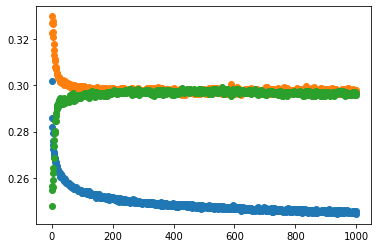

In [ ]:
train_losses, test_losses, acc_roc, best_acc  = train(1000,'simple_model_2',True)
plt.scatter(range(len(train_losses)), train_losses)
plt.scatter(range(len(test_losses)), test_losses)
plt.scatter(range(len(acc_roc)), acc_roc)

In [ ]:
print('Лучшая точность:', np.round((best_acc*100), 2) , '%')

Лучшая точность: 65.43 %


# 5. Поиск оптимальной модели

Попробуем найти оптимальные параметры для модели линейной регресии.

In [ ]:
# Снова обозначим класс модели, где будем менять параметры
# Саму смену параметров оставлю за кадром
class LinearModel(nn.Module):
  def __init__(self, features_shape):
   super(LinearModel, self).__init__() 
   self.classifier = nn.Sequential(
       torch.nn.Linear(features_shape, 1000),
       torch.nn.ReLU(), 
       torch.nn.Dropout(p=0.5), 
       torch.nn.BatchNorm1d(1000), 
       torch.nn.Linear(1000, 700), 
       torch.nn.ReLU(),
       torch.nn.Dropout(p=0.5),
       torch.nn.BatchNorm1d(700),
       torch.nn.Linear(700, 500), 
       torch.nn.ReLU(),
       torch.nn.Dropout(p=0.5),
       torch.nn.BatchNorm1d(500),
       torch.nn.Linear(500,2)
   )
  def forward(self, features):
    prob = self.classifier(features)
    return prob

In [ ]:
# Объявим модель
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LinearModel(train_feat.shape[1])
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)

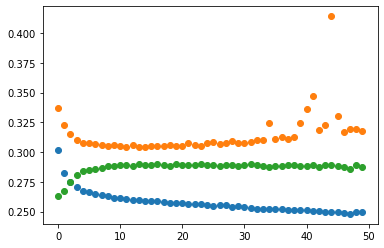

In [ ]:
train_losses, test_losses, acc_roc, best_acc  = train(50,'simple_model_3',True)
plt.scatter(range(len(train_losses)), train_losses)
plt.scatter(range(len(test_losses)), test_losses)
plt.scatter(range(len(acc_roc)), acc_roc)

In [ ]:
# Лучшая точность которую удалось получить при оптимизации модели
print('Лучшая точность:', np.round((best_acc*100), 2) , '%')

Лучшая точность: 66.43 %


In [ ]:
model = LinearModel(train_feat.shape[1])

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Renesans/simple_model_3.pt'))

<All keys matched successfully>

Посмотрим кроме roc_auc, общую точность и точность по классам

In [ ]:
model.eval()

LinearModel(
  (classifier): Sequential(
    (0): Linear(in_features=59, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1000, out_features=700, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): BatchNorm1d(700, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=700, out_features=500, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
    (11): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=500, out_features=2, bias=True)
  )
)

In [ ]:
# общая точность
x = np.array(model(valid_feat).detach().cpu())
x = np.argmax(x,axis =1)
sum(x==y_test)/len(y_test)

0.6642549526270457

In [ ]:
# Точность в предсказании нулевого класса
y0 = np.array(model(valid_feat[0:5804]).detach().cpu())
y0 = np.argmax(y0,axis =1)
sum(y0==y_test[0:5804])/len(y_test[0:5804])

0.5170572019297036

In [ ]:
# Точность первого класса
y1 = np.array(model(valid_feat[5805:]).detach().cpu())
y1 = np.argmax(y1,axis =1)
sum(y1==y_test[5805:])/len(y_test[5805:])

0.8113695090439277

Используем модели решающих деревьев, а именно рандомный лес и решающие деревья с градиентным бустингом, и попробуем найти их оптимальные параметры.

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)

Начнем с решаюих деревьев с градиентным бустингом

In [ ]:
# Поиск оптимальных параметров
param_grid = {'max_depth': [5,8,11,15], 'gamma': [0.01,0.001,0.001],'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,100]}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, refit=True, verbose=0)
xgb_grid.fit(data_train, y_train)
best_model(xgb_grid)

0.7301249436474069
{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 100}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=10, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
# Сузим кол-во параметров
param_grid = {'max_depth': [6,8,7], 'gamma': [0.01],'min_child_weight':[10,15], 'learning_rate': [0.1], 'n_estimators':[100,150]}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, refit=True, verbose=0)
xgb_grid.fit(data_train, y_train)
best_model(xgb_grid)

0.7315994277396546
{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 15, 'n_estimators': 150}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=15, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
x = xgb_grid.predict(valid)

In [ ]:
# Общая точность
sum(x==y_test)/len(y_test)

0.6593453919035315

In [ ]:
# Еще раз
param_grid = {'max_depth': [7,8,9], 'gamma': [0.01],'min_child_weight':[15,20,30], 'learning_rate': [0.1], 'n_estimators':[150,200,250]}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, refit=True, verbose=0)
xgb_grid.fit(data_train, y_train)
best_model(xgb_grid)

0.7315994277396546
{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 15, 'n_estimators': 150}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=15, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
x = xgb_grid.predict(valid)

In [ ]:
# Общая точность
sum(x==y_test)/len(y_test)

0.6593453919035315

Точность более не выросла, считаем что мы нашли оптимальные параметры, посмотрим на ro_auc

In [ ]:
roc_auc_score(x,y_test)

0.706456574805402

Теперь поищем параметры для случайного леса

In [ ]:
param_grid = {'max_depth': [7, 8, 9], 'max_features': [2,4,6,7,8,9],'n_estimators':[120,140,160],'min_samples_split': [3, 5, 6, 7]}
RanFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0)
RanFor_grid.fit(data_train,y_train)
best_model(RanFor_grid)

0.7115343890808196
{'max_depth': 9, 'max_features': 9, 'min_samples_split': 5, 'n_estimators': 120}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',max_depth=9, max_features=9, max_leaf_nodes=None,min_impurity_decrease=0.0,
                            min_impurity_split=None,min_samples_leaf=1, min_samples_split=5,min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
                            oob_score=False, random_state=None, verbose=0,warm_start=False)
RF.fit(data_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
x = RF.predict(valid)

In [ ]:
# Общая точность
sum(x==y_test)/len(y_test)

0.6185185185185185

In [ ]:
# Посмотрим на точность предсказания классов
np.round((sum((RF.predict(valid.iloc[0:5804]) == y_test[0:5804]))/ len(y_test[0:5804])*100), 2)

29.45

In [ ]:
np.round((sum((RF.predict(valid.iloc[5805:]) == y_test[5805:]))/ len(y_test[5805:])*100), 2)

94.25

In [ ]:
roc_auc_score(y_test,x)

0.6185185185185185

Выберем модель решающих деревьев с градиентным бустингом

In [ ]:
XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=15, missing=None, n_estimators=150,n_jobs=1, nthread=None, objective='binary:logistic', random_state=42,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=0.8)
XGB.fit(data_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=15, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.8, verbosity=1)

In [ ]:
# Посмотрим на точность предсказания классов
np.round((sum((XGB.predict(valid.iloc[0:5804]) == y_test[0:5804]))/ len(y_test[0:5804])*100), 2)

42.38

In [ ]:
# И первый класс
np.round((sum((XGB.predict(valid.iloc[5805:]) == y_test[5805:]))/ len(y_test[5805:])*100), 2)

89.49

Нулевой класс предсказывается заметно хуже чем у регрессионной модели. Поэтому главный вопрос выбирая между двумя, какой класс более важен. Сделаем упор на первый, как сказано в условиях задачи. Тогда итоговые предсказания сделаем на модели градиентного бустинга, однако обучим ее еще раз включив валидационную часть.



In [ ]:
# Соеденим признаки
frames = [data_train, valid]
features = pd.concat(frames)

In [ ]:
# Соеденим лейблы
frames = [y_train, y_test]
labels = pd.concat(frames)

In [ ]:
# Перемешаем данные
full = pd.concat([features, labels], axis=1, sort=False)
full = shuffle(full)

In [ ]:
labels = full['POLICY_IS_RENEWED']

In [ ]:
full.drop(['POLICY_IS_RENEWED'], axis='columns', inplace=True)

Обучим модель

In [ ]:
XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=15, missing=None, n_estimators=150,n_jobs=1, nthread=None, objective='binary:logistic', random_state=42,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=0.8)
XGB.fit(full,labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=15, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.8, verbosity=1)

Осталось предсказать классы и вероятности для тестовых данных.

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Renesans/data_test_rdy2.pkl', 'rb') as f:
  data_test = pickle.load(f)

In [ ]:
# Нормализуем только не категориальные данные
feature_columns = ['POLICY_BEGIN_MONTH',
 'POLICY_END_MONTH',
 'POLICY_MIN_AGE',
 'POLICY_MIN_DRIVING_EXPERIENCE',
 'VEHICLE_ENGINE_POWER',
 'VEHICLE_SUM_INSURED',
 'CLAIM_AVG_ACC_ST_PRD',
 'POLICY_YEARS_RENEWED_N',
 'POLICY_DEDUCT_VALUE',
 'POLICY_PRICE_CHANGE',
 'SALE_CHANNEL_FREQ',
 'REGION',
 'INTERMEDIARY',
 'PRICE',
 'YEAR',
 'DTP_ST'
 ]
target_column = ['POLICY_IS_RENEWED']

In [ ]:
# Нормализуем данные
data_test[feature_columns] = (data_test[feature_columns]- 
      data_test[feature_columns].mean()) / data_test[feature_columns].std()

In [ ]:
# Создадим колонку - ответ
data_out = data_test['POLICY_ID']
data_out = data_out.to_frame()

In [ ]:
# Удалим не признаки
data_test.drop(['POLICY_IS_RENEWED'], axis='columns', inplace=True)
data_test.drop(['POLICY_ID'], axis='columns', inplace=True)

Сделаем предсказания класса и вероятность.


In [ ]:
test_class = XGB.predict(data_test)

In [ ]:
pro_class = XGB.predict_proba(data_test)

Добавим данные к таблице.

In [ ]:
data_out['POLICY_IS_RENEWED'] = test_class

In [ ]:
data_out['POLICY_IS_RENEWED_PROBABILITY'] = np.round(pro_class[:, 1:], 4)

In [ ]:
# Посмотрим что получилось
data_out

,POLICY_ID,POLICY_IS_RENEWED,POLICY_IS_RENEWED_PROBABILITY
9,10,1,0.8604
11,12,1,0.7629
12,13,1,0.6691
21,22,1,0.5806
36,37,1,0.8338
...,...,...,...
96562,96574,1,0.7396
96565,96577,1,0.5708
96574,96586,1,0.9083
96583,96595,1,0.7410


In [ ]:
# Сохраним файл
data_out.to_csv('/content/drive/MyDrive/Colab Notebooks/Renesans/data_out.csv', index=False)

Построим рок кривые от моделей


In [ ]:
from sklearn.metrics import roc_curve
def get_auc_scores(y_actual, method, method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

In [ ]:
x = np.array(model(valid_feat).detach().cpu())

auc_linear, fpr_linear, tpr_linear = get_auc_scores(y_test, np.argmax(x,axis =1),x[:, 1:])

auc_RF, fpr_RF, tpr_RF = get_auc_scores(y_test, RF.predict(valid),RF.predict_proba(valid)[:, 1:])

auc_XGB, fpr_XGB, tpr_XGB = get_auc_scores(y_test, XGB.predict(valid),XGB.predict_proba(valid)[:, 1:])

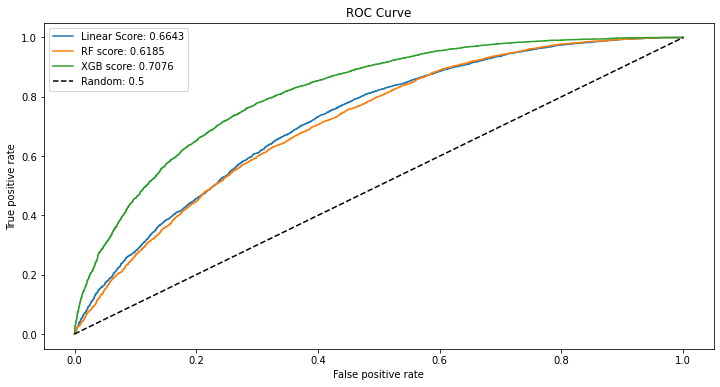

In [ ]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_linear, tpr_linear, label = 'Linear Score: ' + str(round(auc_linear, 4)))

plt.plot(fpr_RF, tpr_RF, label = 'RF score: ' + str(round(auc_RF, 4)))

plt.plot(fpr_XGB, tpr_XGB, label = 'XGB score: ' + str(round(auc_XGB, 4)))

plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig('roc_results_ratios.png')
plt.show()

# 6. Итоги работы.

*Всего работа состоит из пяти глав:*
 
 
1.   В первой главе были первично рассмотрены предлагаемые данные. Сделаны выводы по общему содержанию данных.
2.   Во второй главе была создана простоя полносвязная нейронная сеть, обученная на "сырых данных"
3. Третья глава была посвящена обработке данных. Данные были очищены от выбросов, категориальные параметры были должным образом закодированы и добавлены новые признаки.
4. В четвертой главе была обучена модель, аналогичная модели из второй главы.
5. Пятая глава была посвящена поиску оптимальной модели, были проанализированы и обучены три модели - линейная, случайный лес и градиентного бустинга.



---


*Полученные данные*

В таблице ниже представлены полученные значения каждой модели:

| Модель | Общая точность | Точность 0-го класса | Точность 1-го класса | Roc auc |
| --- | --- | --- | --- | --- |
| Линейная | 66,43 % | 51,71 % | 81,13 % | 66,43 % |
| Случайный лес | 61,85 % | 29,45 % | 94,25 % | 61,85 % |
| Градиентный бустинг | 65,93 % | 42,38 % | 89,49 % | 70,76 % |

График roc auc:

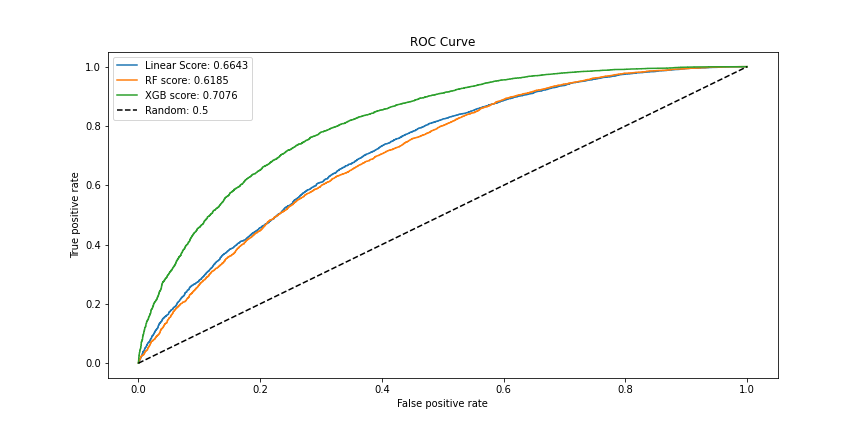

---
В качестве итоговой модели была выбрана модель градиентного бустинга, были получены метки классов и вероятности принадлежности к первому классу, для тестовой выборки.




